In [93]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression

In [94]:
df = pd.read_csv('var3.csv')

In [95]:
df.describe()

,Unnamed: 0,X,y
count,200.000000,2.000000e+02,200.000000
mean,99.500000,1.421085e-16,0.312396
std,57.879185,2.326801e+00,31.846644
min,0.000000,-4.000000e+00,-93.957604
25%,49.750000,-2.000000e+00,-8.162983
50%,99.500000,-2.498002e-16,-0.062606
75%,149.250000,2.000000e+00,10.204757
max,199.000000,4.000000e+00,112.966234


<Axes: >

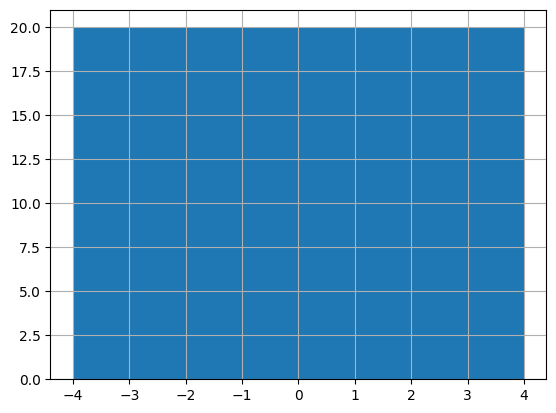

In [96]:
df['X'].hist() # Равномерное распределение (униформное)

In [97]:
df_x_std = (df['X'].max() - df['X'].min()) / (12 ** 0.5) # Стандартное отклонение для униформного распределения)

In [98]:
X, y = torch.tensor(df['X'].values.reshape(-1, 1), dtype=torch.float32),torch.tensor(df['y'].values.reshape(-1, 1), dtype=torch.float32)

In [99]:
# Определение байесовского линейного слоя
class BayesianLinear(nn.Module):
    def __init__(self, in_features, out_features, prior_sigma=df_x_std):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        
        # Weight parameters
        self.weight_mu = nn.Parameter(torch.Tensor(out_features, in_features).normal_(0, 0.1))
        self.weight_rho = nn.Parameter(torch.Tensor(out_features, in_features).normal_(0, 0.1))
        
        # Bias parameters
        self.bias_mu = nn.Parameter(torch.Tensor(out_features).normal_(0, 0.1))
        self.bias_rho = nn.Parameter(torch.Tensor(out_features).normal_(0, 0.1))
        
        # Prior
        self.prior_sigma = prior_sigma
        self.register_buffer('weight_eps', torch.zeros(out_features, in_features))
        self.register_buffer('bias_eps', torch.zeros(out_features))

    def forward(self, x, sample=True):
        if sample:
            # Sample weights
            weight_sigma = torch.log1p(torch.exp(self.weight_rho))
            bias_sigma = torch.log1p(torch.exp(self.bias_rho))
            
            weight = self.weight_mu + weight_sigma * torch.randn_like(weight_sigma)
            bias = self.bias_mu + bias_sigma * torch.randn_like(bias_sigma)
        else:
            weight = self.weight_mu
            bias = self.bias_mu
            
        return F.linear(x, weight, bias)

    def kl_divergence(self):
        weight_sigma = torch.log1p(torch.exp(self.weight_rho))
        bias_sigma = torch.log1p(torch.exp(self.bias_rho))
        
        kl = 0.5 * (
            (weight_sigma**2 + self.weight_mu**2).sum() / self.prior_sigma**2
            - torch.log(weight_sigma**2).sum()
            + (bias_sigma**2 + self.bias_mu**2).sum() / self.prior_sigma**2
            - torch.log(bias_sigma**2).sum()
        ) - (self.in_features + 1) * self.out_features
        
        return kl

In [104]:
# Определение BNN модели
class BNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = BayesianLinear(1, 8)
        self.layer2 = BayesianLinear(8, 1)

    def forward(self, x, sample=True):
        x = self.layer1(x, sample)
        x = self.layer2(x, sample)
        return x

    def kl_loss(self):
        return (self.layer1.kl_divergence() 
    + self.layer2.kl_divergence())

Epoch 0: MSE Loss = 1379.412, KL Loss = -14.830
Epoch 200: MSE Loss = 943.541, KL Loss = -14.377
Epoch 400: MSE Loss = 969.006, KL Loss = -14.021
Epoch 600: MSE Loss = 1405.493, KL Loss = -13.674
Epoch 800: MSE Loss = 1037.174, KL Loss = -13.204
Epoch 1000: MSE Loss = 902.963, KL Loss = -12.737
Epoch 1200: MSE Loss = 684.341, KL Loss = -12.303
Epoch 1400: MSE Loss = 993.635, KL Loss = -11.800
Epoch 1600: MSE Loss = 820.145, KL Loss = -11.212
Epoch 1800: MSE Loss = 776.770, KL Loss = -10.482
Epoch 2000: MSE Loss = 573.111, KL Loss = -9.824
Epoch 2200: MSE Loss = 587.591, KL Loss = -8.998
Epoch 2400: MSE Loss = 279.792, KL Loss = -8.148
Epoch 2600: MSE Loss = 463.080, KL Loss = -7.335
Epoch 2800: MSE Loss = 270.097, KL Loss = -6.550
Epoch 3000: MSE Loss = 505.908, KL Loss = -5.798
Epoch 3200: MSE Loss = 267.629, KL Loss = -5.123
Epoch 3400: MSE Loss = 304.965, KL Loss = -4.458
Epoch 3600: MSE Loss = 268.129, KL Loss = -3.796
Epoch 3800: MSE Loss = 298.653, KL Loss = -3.161
Epoch 4000: MS

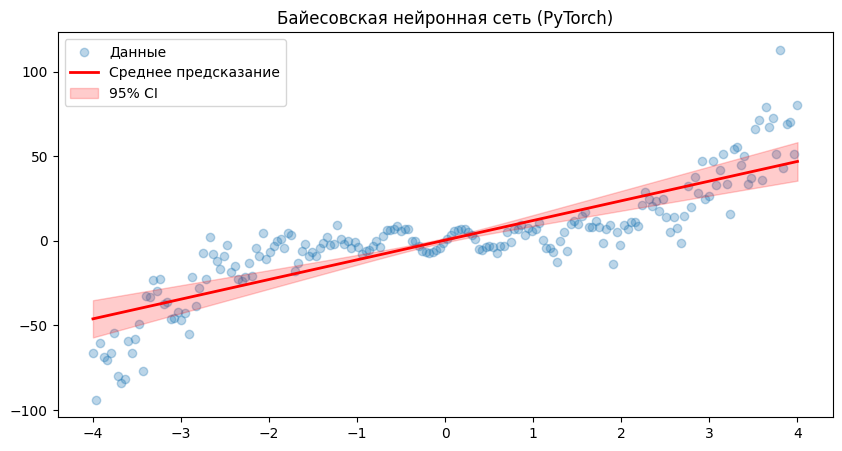

In [105]:
# Обучение модели
model = BNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
n_epochs = 7000

for epoch in range(n_epochs):
    optimizer.zero_grad()
    
    # Forward pass с сэмплированными весами
    preds = model(X)
    
    # Расчет потерь
    mse_loss = F.mse_loss(preds, y)
    kl_loss = model.kl_loss()
    total_loss = mse_loss + kl_loss / len(X)
    
    # Backpropagation
    total_loss.backward()
    optimizer.step()
    
    if epoch % 200 == 0:
        print(f'Epoch {epoch}: MSE Loss = {mse_loss.item():.3f}, KL Loss = {kl_loss.item():.3f}')

# Визуализация предсказаний
model.eval()
with torch.no_grad():
    samples = [model(X).numpy() for _ in range(100)]
    y_mean = np.mean(samples, axis=0)
    y_std = np.std(samples, axis=0)

plt.figure(figsize=(10, 5))
plt.scatter(X.numpy(), y.numpy(), alpha=0.3, label='Данные')
plt.plot(X.numpy(), y_mean, 'r', lw=2, label='Среднее предсказание')
plt.fill_between(X.numpy().ravel(), 
                y_mean.ravel() - 2*y_std.ravel(),
                y_mean.ravel() + 2*y_std.ravel(),
                alpha=0.2, color='r', label='95% CI')
plt.legend()
plt.title('Байесовская нейронная сеть (PyTorch)')
plt.show()

In [225]:
class BayesianNonlinear(nn.Module):
    def __init__(self, in_features, out_features, activation='sigmoid'):
        super().__init__()
        self.linear = BayesianLinear(in_features, out_features)
        self.activation = activation

    def forward(self, x, sample=True):
        x = self.linear(x, sample)
        if self.activation == 'relu':
            return F.relu(x)
        elif self.activation == 'softmax':
            return F.softmax(x)
        elif self.activation == 'sigmoid':
            return F.sigmoid(x)
        return x

    def kl_divergence(self):
        return self.linear.kl_divergence()

class BNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = BayesianLinear(1, 128)
        self.layer2 = BayesianNonlinear(128, 64, 'sigmoid')
        self.layer3 = BayesianLinear(64, 1)


    def forward(self, x, sample=True):
        x = F.relu(self.layer1(x, sample))
        x = self.layer2(x, sample)
        x = self.layer3(x, sample)

        return x

    def kl_loss(self):
        return (self.layer1.kl_divergence() 
    + self.layer2.kl_divergence()
    + self.layer3.kl_divergence())

In [226]:
# Обучение (аналогично предыдущему, но с увеличенным числом эпох)
model = BNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
n_epochs = 15000

for epoch in range(n_epochs):
    optimizer.zero_grad()
    preds = model(X)
    mse_loss = F.mse_loss(preds, y)
    kl_loss = model.kl_loss()
    total_loss = mse_loss + kl_loss / len(X)
    total_loss.backward()
    optimizer.step()
    
    if epoch % 300 == 0: 
        print(f'Epoch {epoch}: MSE Loss = {mse_loss.item():.3f}, KL Loss = {kl_loss.item():.3f}')

    if mse_loss.item() <= 14 and kl_loss.item() <= 500:
        print(f"Ранняя остановка на эпохе {epoch}: MSE Loss = {mse_loss.item():.3f}, KL Loss = {kl_loss.item():.3f}")
        break

# Визуализация (аналогично предыдущей)
model.eval()
with torch.no_grad():
    samples = [model(X).numpy() for _ in range(100)]
    y_mean = np.mean(samples, axis=0)
    y_std = np.std(samples, axis=0)

plt.figure(figsize=(10, 5))
plt.scatter(X.numpy(), y.numpy(), alpha=0.3, label='Данные')
plt.plot(X.numpy(), y_mean, 'r', lw=2, label='Среднее предсказание')
plt.fill_between(X.numpy().ravel(), 
                y_mean.ravel() - 2*y_std.ravel(),
                y_mean.ravel() + 2*y_std.ravel(),
                alpha=0.2, color='r', label='95% CI')
plt.legend()
plt.title('Байесовская нейронная сеть с нелинейными слоями (PyTorch)')
plt.show()

Epoch 0: MSE Loss = 1187.544, KL Loss = -5035.089
Epoch 300: MSE Loss = 883.917, KL Loss = -5104.629
Epoch 600: MSE Loss = 586.380, KL Loss = -5047.233
Epoch 900: MSE Loss = 303.170, KL Loss = -4955.589
Epoch 1200: MSE Loss = 186.585, KL Loss = -4802.924
Epoch 1500: MSE Loss = 215.574, KL Loss = -4731.392
Epoch 1800: MSE Loss = 141.817, KL Loss = -4726.307
Epoch 2100: MSE Loss = 160.765, KL Loss = -4756.516
Epoch 2400: MSE Loss = 154.333, KL Loss = -4816.277
Epoch 2700: MSE Loss = 127.570, KL Loss = -4898.254
Epoch 3000: MSE Loss = 131.510, KL Loss = -4997.482
Epoch 3300: MSE Loss = 117.861, KL Loss = -5119.653
Epoch 3600: MSE Loss = 121.281, KL Loss = -5260.296
Epoch 3900: MSE Loss = 117.592, KL Loss = -5419.200
Epoch 4200: MSE Loss = 129.781, KL Loss = -5599.923
Epoch 4500: MSE Loss = 113.116, KL Loss = -5776.776
Epoch 4800: MSE Loss = 111.679, KL Loss = -5968.224
Epoch 5100: MSE Loss = 101.433, KL Loss = -6155.082
Epoch 5400: MSE Loss = 100.079, KL Loss = -6357.564
Epoch 5700: MSE L

KeyboardInterrupt: 

self.layer1 = BayesianLinear(1, 16)
self.layer2 = BayesianNonlinear(16, 16, 'relu')
self.layer3 = BayesianNonlinear(16, 9, 'relu')
self.layer4 = BayesianLinear(9, 1)

Epoch 14700: MSE Loss = 94.208, KL Loss = -160.332


self.layer1 = BayesianLinear(1, 32)
        self.layer2 = BayesianNonlinear(32, 16, 'relu')
        self.layer3 = BayesianNonlinear(16, 9, 'relu')
        self.layer4 = BayesianLinear(9, 1)

Epoch 14700: MSE Loss = 101.043, KL Loss = -572.189


        self.layer1 = BayesianLinear(1, 16)
        self.layer2 = BayesianNonlinear(16, 8, 'relu')
        self.layer3 = BayesianNonlinear(8, 4, 'relu')
        self.layer4 = BayesianLinear(4, 1)

        Epoch 14700: MSE Loss = 99.652, KL Loss = 297.138


self.layer1 = BayesianLinear(1, 32)
        self.layer2 = BayesianNonlinear(32, 16, 'sigmoid')
        self.layer3 = BayesianNonlinear(16, 8, 'relu')
        self.layer4 = BayesianLinear(8, 1)

        Epoch 14700: MSE Loss = 75.948, KL Loss = -119.026
